# Tracking through elements with autodiff

In [1]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
from pytao import Tao
import matplotlib.pyplot as plt
import numdifftools as nd
from bmadx.track import *
tkwargs = {
    "dtype" : torch.double
}
import time
np.set_printoptions(precision= 16, suppress=False)
torch.set_printoptions(precision= 16, sci_mode=True)
torch.__version__, np.__version__

('1.11.0', '1.22.4')

# Constants

In [2]:
c_light = 2.99792458e8 #speed of light in m/s
m_e = 0.510998950e6 #electron mass in eV

# Drift tests

In [3]:
# Create drift
L=1.0 # Drift length in m
d1 = Drift(L=torch.tensor(L, **tkwargs)) #named tuple is in track.py module
d1

Drift(L=tensor(1.0000000000000000e+00, dtype=torch.float64))

## Drift one particle test

In [4]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
p_in = Particle(*tvec1,ts, tp0c, tmc2)
p_in

Particle(x=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), px=tensor(3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), y=tensor(-3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), py=tensor(-1.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), z=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), pz=tensor(-2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), s=tensor(0., dtype=torch.float64), p0c=tensor(4.0000000000000000e+07, dtype=torch.float64), mc2=tensor( 5.1099895000000001e+05, dtype=torch.float64))

In [5]:
#create track_a_drift_torch
track_a_drift_torch = make_track_a_drift(torch)
# Outgoing particle
p_out = track_a_drift_torch(p_in, d1)
x_py = torch.hstack([p_out.x,p_out.px,p_out.y,p_out.py,p_out.z,p_out.pz]).detach()
x_py

tensor([5.0060271145229325e-03, 3.0000000000000001e-03, -4.0020090381743109e-03,
        -1.0000000000000000e-03, 1.9946525738924175e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [6]:
# bmad lattice for comparison
tao = Tao('-lat ../bmad_lattices/test_drift.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out=tao.orbit_at_s(ele=1)
#orbit_out

In [7]:
# bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([5.0060271145229299e-03, 3.0000000000000001e-03, -4.0020090381743100e-03,
        -1.0000000000000000e-03, 1.9946525738923598e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [8]:
torch.allclose(x_py, x_tao)

True

## Drift Jacobian test

In [9]:
f_drift = lambda x: track_a_drift_torch(Particle(*x, ts, tp0c, tmc2), d1)[:6]
J = jacobian(f_drift, tvec1)

In [10]:
# Jacobian matrix
mat_py = torch.vstack(J)
mat_py

tensor([[ 1.0000000000000000e+00,  1.0020180925273929e+00,
          0.0000000000000000e+00, -3.0181176940051169e-06,
          0.0000000000000000e+00, -3.0120814586171068e-03],
        [ 0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0181176940051169e-06,
          1.0000000000000000e+00,  1.0020100442135422e+00,
          0.0000000000000000e+00,  1.0040271528723688e-03],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0120814586171063e-03,
          0.0000000000000000e+00,  1.0040271528723688e-03,
          1.0000000000000000e+00,  1.7421652474771806e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [11]:
# Tao Jacobian
drift_tao = tao.matrix(0,1)
mat_tao = torch.tensor(drift_tao['mat6'], **tkwargs)
mat_tao

tensor([[ 1.0000000000000000e+00,  1.0020180925273900e+00,
          0.0000000000000000e+00, -3.0181176940051199e-06,
          0.0000000000000000e+00, -3.0120814586171098e-03],
        [ 0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0181176940051199e-06,
          1.0000000000000000e+00,  1.0020100442135400e+00,
          0.0000000000000000e+00,  1.0040271528723699e-03],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0120814586171098e-03,
          0.0000000000000000e+00,  1.0040271528723699e-03,
          1.0000000000000000e+00,  1.7421652474810300e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [12]:
# is it close to Tao result?
torch.allclose(mat_py, mat_tao)

True

# Quadrupole tests

In [13]:
def torchquadrupole(L: torch.Tensor, K1: torch.Tensor, NUM_STEPS=1,
                    X_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                    Y_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                    TILT: torch.Tensor=torch.tensor(0.0,**tkwargs)):
    return Quadrupole(L=L, K1=K1, NUM_STEPS=NUM_STEPS, X_OFFSET=X_OFFSET,
                     Y_OFFSET=Y_OFFSET, TILT=TILT)

In [14]:
# Create quad
L = 0.1 #Length in m
K1 = 10 #Quad focusing strength. Positive is focusing in x
#NUM_STEPS = 1 #number of divisions for tracking. 1 is bmad default when there are no other multipoles
q1 = torchquadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs))
q1

Quadrupole(L=tensor(1.0000000000000001e-01, dtype=torch.float64), K1=tensor(1.0000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64))

## Quadrupole one particle test

In [15]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs) 
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
p_in = Particle(*tvec1,ts, tp0c, tmc2)
p_in

Particle(x=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), px=tensor(3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), y=tensor(-3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), py=tensor(-1.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), z=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), pz=tensor(-2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), s=tensor(0., dtype=torch.float64), p0c=tensor(4.0000000000000000e+07, dtype=torch.float64), mc2=tensor( 5.1099895000000001e+05, dtype=torch.float64))

In [16]:
# create track_a_quadrupole_torch
track_a_quadrupole_torch = make_track_a_quadrupole(torch)
# Outgoing particle
p_out = track_a_quadrupole_torch(p_in, q1)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.1962397193025516e-03, 8.8418342648533682e-04, -3.2534419732692245e-03,
        -4.1008717415728594e-03, 1.9993946642253308e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [17]:
# Bmad lattice to compare
tao = Tao('-lat ../bmad_lattices/test_quad.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

In [18]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.1962397193025498e-03, 8.8418342648533704e-04, -3.2534419732692201e-03,
        -4.1008717415728603e-03, 1.9993946642253299e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [19]:
# close to Tao result?
torch.allclose(x_py, x_tao)

True

## Quadrupole Jacobian test

In [20]:
f_quadrupole = lambda x: track_a_quadrupole_torch(Particle(*x,ts, tp0c, tmc2), q1)[:6]
J = jacobian(f_quadrupole, tvec1)

In [21]:
# Jacobian matrix
mat_py = torch.vstack(J)
mat_py

tensor([[ 9.5031674318754977e-01,  9.8535410975817278e-02,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00, -1.9248585503177227e-04],
        [-9.8338340153865633e-01,  9.5031674318754977e-01,
         -0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  1.1496639089440819e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          1.0505199385060540e+00,  1.0188215775106230e-01,
          0.0000000000000000e+00,  2.5690939373378331e-04],
        [-0.0000000000000000e+00,  0.0000000000000000e+00,
          1.0167839343556018e+00,  1.0505199385060540e+00,
          0.0000000000000000e+00,  1.0174858226574043e-04],
        [ 8.0032908698420230e-05, -1.9425079143865157e-04,
          1.5433242974866441e-04,  2.5952207539749645e-04,
          1.0000000000000000e+00,  1.7567092021426940e-05],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [22]:
# Bmad Jacobian
quad_tao = tao.matrix(0,1)
mat_tao = torch.tensor(quad_tao['mat6'], **tkwargs)
mat_tao

tensor([[ 9.5031674318754999e-01,  9.8535410975817306e-02,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00, -1.9248585503177200e-04],
        [-9.8338340153865600e-01,  9.5031674318754999e-01,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  1.1496639089440800e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          1.0505199385060500e+00,  1.0188215775106201e-01,
          0.0000000000000000e+00,  2.5690939373378298e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          1.0167839343556000e+00,  1.0505199385060500e+00,
          0.0000000000000000e+00,  1.0174858226574100e-04],
        [ 8.0032908698420203e-05, -1.9425079143865201e-04,
          1.5433242974866401e-04,  2.5952207539749601e-04,
          1.0000000000000000e+00,  1.7567092021426899e-05],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [23]:
# close to Tao result?
torch.allclose(mat_py, mat_tao)

True

## Quadrupole offset test

In [24]:
# Quad params
L = 0.1 #Length in m
K1 = 10 #Quad focusing strength. Positive is focusing in x

# quad w/o offsets
q_no_off = torchquadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs))
# quad with offsets
x_off = 1e-3
y_off = -2e-3
q_off = torchquadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs), 
                   X_OFFSET=torch.tensor(x_off, **tkwargs),
                   Y_OFFSET=torch.tensor(y_off, **tkwargs) )

In [25]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs) 
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
p_in = Particle(*tvec1,ts, tp0c, tmc2)
p_in

Particle(x=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), px=tensor(3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), y=tensor(-3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), py=tensor(-1.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), z=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), pz=tensor(-2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), s=tensor(0., dtype=torch.float64), p0c=tensor(4.0000000000000000e+07, dtype=torch.float64), mc2=tensor( 5.1099895000000001e+05, dtype=torch.float64))

In [26]:
# Outgoing particle no offset
p_out = track_a_quadrupole_torch(p_in, q_no_off)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.1962397193025516e-03, 8.8418342648533682e-04, -3.2534419732692245e-03,
        -4.1008717415728594e-03, 1.9993946642253308e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [27]:
# Outgoing particle offset
p_out = track_a_quadrupole_torch(p_in, q_off)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.2459229761150018e-03, 1.8675668280239931e-03, -3.1524020962571163e-03,
        -2.0673038728616557e-03, 1.9995386064283046e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [28]:
%%time
# Bmad lattice to compare
tao = Tao('-lat ../bmad_lattices/test_quad_offset.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

CPU times: user 5.24 ms, sys: 2.55 ms, total: 7.8 ms
Wall time: 8.41 ms


In [29]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.2459229761150000e-03, 1.8675668280239901e-03, -3.1524020962571198e-03,
        -2.0673038728616601e-03, 1.9995386064282999e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [30]:
# close to Tao result?
torch.allclose(x_py, x_tao)

True

## Quadrupole tilt test (transverse rotation)

In [31]:
# Quad params
L = 0.1 #Length in m
K1 = 10 #Quad focusing strength. Positive is focusing in x

# quad w/o offsets
q_no_off = torchquadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs))
# quad with offsets
tilt = 0.3
q_off = torchquadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs),
                        TILT = torch.tensor(tilt, **tkwargs))

In [32]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs) 
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
p_in = Particle(*tvec1,ts, tp0c, tmc2)
p_in

Particle(x=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), px=tensor(3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), y=tensor(-3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), py=tensor(-1.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), z=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), pz=tensor(-2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), s=tensor(0., dtype=torch.float64), p0c=tensor(4.0000000000000000e+07, dtype=torch.float64), mc2=tensor( 5.1099895000000001e+05, dtype=torch.float64))

In [33]:
# Outgoing particle no offset
p_out = track_a_quadrupole_torch(p_in, q_no_off)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.1962397193025516e-03, 8.8418342648533682e-04, -3.2534419732692245e-03,
        -4.1008717415728594e-03, 1.9993946642253308e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [34]:
# Outgoing particle offset
p_out = track_a_quadrupole_torch(Particle(*tvec1,ts, tp0c, tmc2), q_off)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.3004318127568596e-03, 2.9821529561669434e-03, -3.2863103534060884e-03,
        -4.7823316819364681e-03, 1.9990464049858686e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [35]:
%%time
# Bmad lattice to compare
tao = Tao('-lat ../bmad_lattices/test_quad_tilt.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

CPU times: user 7.47 ms, sys: 95 µs, total: 7.56 ms
Wall time: 8.36 ms


In [36]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.3004318127568600e-03, 2.9821529561669400e-03, -3.2863103534060902e-03,
        -4.7823316819364699e-03, 1.9990464049858699e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [37]:
# close to Tao result?
torch.allclose(x_py, x_tao)

True

# Lattice tracking

## Lattice one particle test

In [38]:
# Create drift
L_d = 1.0 # Drift length in m
d1 = Drift(torch.tensor(L_d, **tkwargs))
# Create quad
L_q = 0.1  # quad length in m
K1 = 10  # Quad focusing strength. Positive is focusing in x
#NUM_STEPS = 1  # number of divisions for tracking. 1 is bmad default when there are no other multipoles
q1 = torchquadrupole(L=torch.tensor(L_q, **tkwargs), K1=torch.tensor(K1, **tkwargs))

In [39]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07  # Reference particle momentum in eV
mc2 = 1*m_e  # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
p_in = Particle(*tvec1, ts, tp0c, tmc2)
p_in

Particle(x=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), px=tensor(3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), y=tensor(-3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), py=tensor(-1.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), z=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), pz=tensor(-2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), s=tensor(0., dtype=torch.float64), p0c=tensor(4.0000000000000000e+07, dtype=torch.float64), mc2=tensor( 5.1099895000000001e+05, dtype=torch.float64))

In [40]:
# Lattice example
lattice = [d1, q1, d1, q1, d1]  # lattice is a list of elements
# List of particle coordinates after each element:
x_list = [torch.hstack(coords[:6]).detach() for coords in track_a_lattice(p_in, lattice)]
# Outgoing particle after complete lattice:
x_py = torch.hstack(track_a_lattice(p_in, lattice)[-1][:6]).detach()
# alternative: x_list[-1]
x_py

tensor([-2.2819679612099907e-03, -4.8963303496563082e-03, -2.5439131659086591e-02,
        -1.4972829678474660e-02, 1.8473246819740532e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [41]:
# Bmad lattice to compare
tao = Tao('-lat ../bmad_lattices/test_drift_quad.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=5)

In [42]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([-2.2819679612099898e-03, -4.8963303496563099e-03, -2.5439131659086602e-02,
        -1.4972829678474700e-02, 1.8473246819741701e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [43]:
# close to Tao result?
torch.allclose(x_py, x_tao)

True

## Lattice Jacobian test

In [44]:
f_driftquadrupole = lambda x: track_a_lattice(Particle(*x, ts, tp0c, tmc2), lattice)[-1][:6]
J = jacobian(f_driftquadrupole, tvec1)

In [45]:
# Jacobian matrix
mat_py = torch.vstack(J)
mat_py

tensor([[-1.0322023903174575e+00, -7.2569681151011811e-02,
          2.3367174796365382e-04,  4.0490038958197793e-04,
          0.0000000000000000e+00,  8.2182839451539688e-03],
        [-9.0005153171126384e-01, -1.0320809782928480e+00,
         -1.0670671153299335e-05, -1.9000372936436179e-05,
          0.0000000000000000e+00,  5.5475642315005796e-04],
        [-8.8127328798467028e-05, -9.3392943713694148e-05,
          5.4572583903073202e+00,  9.0710195783967222e+00,
          0.0000000000000000e+00,  3.3612658955446149e-02],
        [-1.0670671153299331e-05, -9.9546185436680993e-06,
          3.1722681310803358e+00,  5.4561657512786770e+00,
          0.0000000000000000e+00,  9.3914704183099551e-03],
        [-6.8237891712833116e-03, -8.4411335413884098e-03,
          5.5376468742080333e-02,  9.8205645796140759e-02,
          1.0000000000000000e+00,  9.9199631964399224e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [46]:
# Bmad Jacobian
lat_tao = tao.matrix(0,5)
mat_tao = torch.tensor(lat_tao['mat6'], **tkwargs)
mat_tao

tensor([[-1.0322023903174600e+00, -7.2569681151011395e-02,
          2.3367174796365400e-04,  4.0490038958197798e-04,
          0.0000000000000000e+00,  8.2182839451539601e-03],
        [-9.0005153171126395e-01, -1.0320809782928499e+00,
         -1.0670671153299301e-05, -1.9000372936436199e-05,
          0.0000000000000000e+00,  5.5475642315005796e-04],
        [-8.8127328798467001e-05, -9.3392943713694094e-05,
          5.4572583903073202e+00,  9.0710195783967205e+00,
          0.0000000000000000e+00,  3.3612658955446101e-02],
        [-1.0670671153299301e-05, -9.9546185436680993e-06,
          3.1722681310803398e+00,  5.4561657512786796e+00,
          0.0000000000000000e+00,  9.3914704183099499e-03],
        [-6.8237891712833098e-03, -8.4411335413884098e-03,
          5.5376468742080298e-02,  9.8205645796140703e-02,
          1.0000000000000000e+00,  9.9199631964514605e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [47]:
# close to Tao result?
torch.allclose(mat_py, mat_tao)

True

## Multi-particle propagation through lattice

In [48]:
# Particle bunch with Gaussian distribution
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
p_in = Particle(*sample.T, ts, tp0c, tmc2)

In [49]:
p_out = track_a_lattice(p_in, lattice)

In [50]:
# some beam properties up and downstream
torch.std(p_out[0].y),torch.std(p_out[-1].y)

(tensor(1.0074333982775488e-03, dtype=torch.float64),
 tensor(1.3746881079501517e-02, dtype=torch.float64))

## Stub element test

In [51]:
# divide a quad into 10 parts
divided_quad = stub_element(q1, 10)
divided_quad

[Quadrupole(L=tensor(1.0000000000000000e-02, dtype=torch.float64), K1=tensor(1.0000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64)),
 Quadrupole(L=tensor(1.0000000000000000e-02, dtype=torch.float64), K1=tensor(1.0000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64)),
 Quadrupole(L=tensor(1.0000000000000000e-02, dtype=torch.float64), K1=tensor(1.0000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64)),
 Quadrupole(L=tensor(1.0000000000000000e-02, dtype=torch.float64), K1=tensor(1.0000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TIL

## Plotting using stub_element

In [52]:
# make a quadrupole triplet
L_d = 1.5  # Drift length in m
d1 = Drift(torch.tensor(L_d, **tkwargs)) # drift
L_q = 0.1  # Quadrupole length in m
K1 = 10  # Quadrupole strengths
NUM_STEPS = 1
q1 = torchquadrupole(L=torch.tensor(L_q,**tkwargs), K1=torch.tensor(K1, **tkwargs))  # x-focusing
q2 = torchquadrupole(L=torch.tensor(L_q,**tkwargs), K1=torch.tensor(-K1, **tkwargs))  # y-focusing
lattice = [d1, q1, d1, q2, d1, q1, d1]

# stub each element into n equal parts each
n=50
stubbed_lattice = stub_lattice(lattice, n)

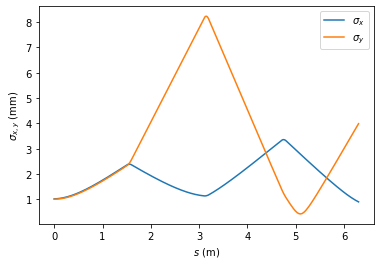

In [53]:
all_p = track_a_lattice(p_in, stubbed_lattice)
stdx = np.array([torch.std(par.x).item() for par in all_p])
stdy = np.array([torch.std(par.y).item() for par in all_p])
s = np.array([par.s.item() for par in all_p])
plt.plot(s, stdx*1000, label=r'$\sigma_x$')
plt.plot(s, stdy*1000, label=r'$\sigma_y$')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()

# Hessian Matrix example

In [54]:
# Particle bunch with Gaussian distribution
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
p_in = Particle(*sample.T, ts, tp0c, tmc2)

L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(torch.tensor(L_d, **tkwargs))

def sigmax_end(k1s):
    """returns x beamsize after lattice composed by len(k1s)+1 
    drifts with len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    
    for k1 in k1s:
        lattice.append(torchquadrupole(L=torch.tensor(L_q, **tkwargs), K1=k1))
        lattice.append(drift)

    p_out = track_a_lattice(p_in, lattice)[-1]
    return torch.std(p_out.x)

#k1s = torch.tensor([10,-10,10,-10,10,-10,10,-10,10,-10], **tkwargs)
k1s = torch.zeros(10, **tkwargs)

In [55]:
#Hessian using autodiff
%time
hessian_py = hessian(sigmax_end,k1s)
hessian_py

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 10.3 µs


tensor([[6.1760138610831571e-05, 1.9859454239588780e-04, 3.1650583325387640e-04,
         3.9896362731531483e-04, 4.4596792458020311e-04, 4.5751872504854119e-04,
         4.3361602872032896e-04, 3.7425983559556659e-04, 2.7945014567425395e-04,
         1.4918695895639123e-04],
        [1.9859454239588788e-04, 4.0437464829658020e-05, 3.0100195813375697e-04,
         5.1803541758263776e-04, 6.6122672687384692e-04, 7.3057588600738445e-04,
         7.2608289498325034e-04, 6.4774775380144461e-04, 4.9557046246196735e-04,
         2.6955102096481835e-04],
        [3.1650583325387640e-04, 3.0100195813375686e-04, 2.5188599288716922e-05,
         3.7413585438380963e-04, 6.5150126000558604e-04, 8.1666109554546064e-04,
         8.6961536100343376e-04, 8.1036405637950485e-04, 6.3890718167367445e-04,
         3.5524473688594224e-04],
        [3.9896362731531494e-04, 5.1803541758263765e-04, 3.7413585438380963e-04,
         1.4733134506709147e-05, 4.1679152397542068e-04, 7.1577435366277004e-04,
       

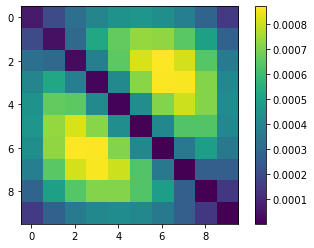

In [56]:
plt.imshow(hessian_py.detach().numpy())
plt.colorbar()
#plt.savefig("hessian.eps")

In [57]:
#Hessian using numerical differentiation

p_in = Particle(*sample.detach().numpy().T, 0, p0c, mc2)

L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(L_d)
def sigmax_end2(k1s):
    """returns x beamsize after lattice composed by len(k1s)+1 
    drifts with len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    
    for k1 in k1s:
        lattice.append(Quadrupole(L=L_q, K1=k1))
        lattice.append(drift)

    p_out = track_a_lattice(p_in, lattice)[-1]
    
    return np.std(p_out.x)

#k1s = np.array([10,-10,10,-10,10,-10,10,-10,10,-10])
k1s = np.zeros(10)

In [58]:
%time
hessian_nd = nd.Hessian(sigmax_end2)(k1s)
hessian_nd

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.68 µs


array([[6.7382686425249892e-05, 2.2181580925172072e-04,
        3.4487424318826846e-04, 4.3076370344291760e-04,
        4.7948419002826289e-04, 4.9103570291663225e-04,
        4.6541824213751761e-04, 4.0263180767539957e-04,
        3.0267639953732032e-04, 1.6555201771964090e-04],
       [2.2181580925172072e-04, 5.0661683043711430e-05,
        3.3621235423416588e-04, 5.5661016225734897e-04,
        7.0146954231539325e-04, 7.7079049449625811e-04,
        7.6457301876310831e-04, 6.8281711512596774e-04,
        5.2552278357757549e-04, 2.9269002412258313e-04],
       [3.4487424318826846e-04, 3.3621235423416588e-04,
        3.8855977805474738e-05, 4.1788361867434962e-04,
        6.9684997826831578e-04, 8.6193367655802179e-04,
        9.1313471352864634e-04, 8.5045308917838965e-04,
        6.7388880350709689e-04, 3.8344185651289510e-04],
       [4.3076370344291760e-04, 5.5661016225734897e-04,
        4.1788361867434962e-04, 3.0685803648518652e-05,
        4.6562549789185080e-04, 7.64465249115

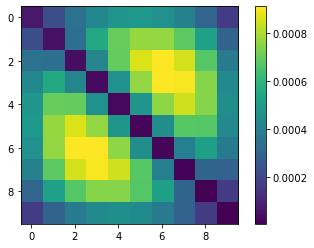

In [59]:
plt.imshow(hessian_nd)
plt.colorbar()

In [60]:
np.allclose(hessian_nd, hessian_py.detach().numpy())

False

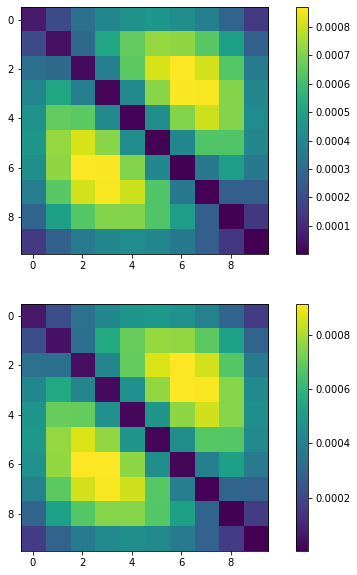

In [61]:
fig, axs = plt.subplots(2, figsize=(10,10))
cm = axs[0].imshow(hessian_py.detach().numpy())
fig.colorbar(cm,ax=axs[0])
#ax.imshow(hessian_py.detach().numpy())
#ax = axs[1]
#ax.imshow(1-hessian_nd)
cm = axs[1].imshow(hessian_nd)
fig.colorbar(cm,ax=axs[1])

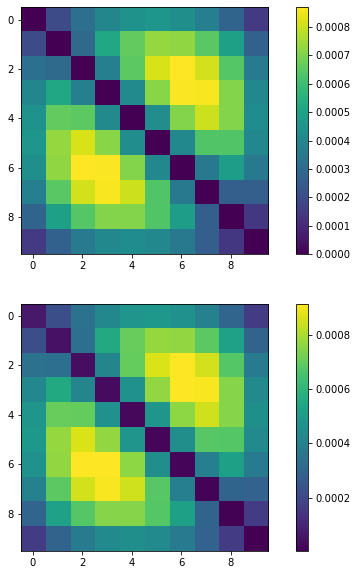

In [62]:
hessian_numpy = hessian_py.detach().numpy()
for i in range(len(hessian_nd[:,0])):
    hessian_numpy[i,i]=0
fig, axs = plt.subplots(2, figsize=(10,10))
cm = axs[0].imshow(hessian_numpy)
fig.colorbar(cm,ax=axs[0])
#ax.imshow(hessian_py.detach().numpy())
#ax = axs[1]
#ax.imshow(1-hessian_nd)
cm = axs[1].imshow(hessian_nd)
fig.colorbar(cm,ax=axs[1])